<!-- PROJECT LOGO -->
<br />
<div align="center">
  <a>
    <!-- <img src="https://res.cloudinary.com/dek4evg4t/image/upload/v1725947133/Frame_10507_1.png" alt="Logo" width="40%"> -->
  </a>
</div>


### 🖹 Descripción: 
<!-- Este notebook tiene como objetivo principal aplicar diversas técnicas de clasificación de datos en el conjunto de datos provienente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales, y su finalidad es predecir de manera diagnóstica si un paciente tiene diabetes, basándose en un conjunto de mediciones realizadas. Enlace: [Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database). Con el fin de de explorar herramientas avanzadas de Machine Learning y contribuir al desarrollo del conocimiento a través de la investigación. -->

### ✍️ Autores: 
* Angelo Ortiz Vega - [@angelortizv](https://github.com/angelortizv)
* Alejandro Campos Abarca - [@MajinLoop](https://github.com/MajinLoop)

### 📅 Fecha: 
9 de octubre de 2024

### 📝 Notas: 
<!-- Este notebook es el primero de dos que forman parte del primer proyecto del curso IC6200 - Inteligencia Artificial. Este notebook está titulado "diabetes", mientras que el siguiente se llama "alzheimer". -->

### Otras notas:
<!-- - Asegurarse de que Python esté instalado, junto con las bibliotecas necesarias: pandas, numpy, matplotlib, seaborn, scipy, ydata_profiling, utils. -->


# Importación de Librerías

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from pathlib import Path
import os

import Utils as U

## Verificar PyThorch y CUDA

In [2]:
print("CUDA available:", torch.cuda.is_available())
if(torch.cuda.is_available()):
    print("CUDA version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())

CUDA available: True
CUDA version: 12.1
Number of GPUs: 1
Current GPU: 0


# Definición de Constantes

In [4]:
# IMG_HEIGHT = 150
# IMG_WIDTH = 150
BATCH_SIZE = 32
EPOCHS = 5
TRAIN_DATA_PATH = 'data/Covid19-dataset/train'
TEST_DATA_PATH = 'data/Covid19-dataset/test'
IMAGE_RESIZE = 128
IMAGE_NORMALIZE = 0.5


## Filtros

In [5]:
def gausian_blur(img, order=21, sigma=21):
    np_img = np.array(img)
    filtered_img = cv2.GaussianBlur(np_img, (order,order), sigma)
    return Image.fromarray(filtered_img)

def bilateral_filter(img):
    """
    d: Diameter of each pixel neighborhood.
    
    sigmaColor: Value of \sigma in the color space. The greater the value, the colors farther to each other will start to get mixed.
    
    sigmaSpace: Value of \sigma in the coordinate space. The greater its value, the more further pixels will mix together, given that
    their colors lie within the sigmaColor range.    
    """
    np_img = np.array(img)
    filtered_img = cv2.bilateralFilter(np_img, 15, 75, 75)
    return Image.fromarray(filtered_img) 

def canny_edge_filter(img, min_val=40, max_val=85):
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # PIL (RGB) -> OpenCV (BGR)
    img = cv2.Canny(img, min_val, max_val)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV (BGR) -> PIL (RGB)
    return Image.fromarray(img)

# Creación de los dataframes

In [6]:
transform_r = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)
transform_b = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Lambda(lambda img: bilateral_filter(img)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)
transform_c = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Lambda(lambda img: canny_edge_filter(img)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)


train_dataset_r = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_r)
train_dataset_b = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_b)
train_dataset_c = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_c)

train_loader_r = DataLoader(dataset=train_dataset_r, batch_size=BATCH_SIZE, shuffle=True)
train_loader_b = DataLoader(dataset=train_dataset_b, batch_size=BATCH_SIZE, shuffle=True)
train_loader_c = DataLoader(dataset=train_dataset_c, batch_size=BATCH_SIZE, shuffle=True)


test_dataset_r = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_r)
test_dataset_b = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_b)
test_dataset_c = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_c)

test_loader_r = DataLoader(dataset=test_dataset_r, batch_size=BATCH_SIZE, shuffle=False)
test_loader_b = DataLoader(dataset=test_dataset_b, batch_size=BATCH_SIZE, shuffle=False)
test_loader_c = DataLoader(dataset=test_dataset_c, batch_size=BATCH_SIZE, shuffle=False)


print(f'Tamaño del conjunto de entrenamiento: {len(train_dataset_r)}')
print(f'Tamaño del conjunto de testing: {len(test_dataset_r)}')

Tamaño del conjunto de entrenamiento: 251
Tamaño del conjunto de testing: 66


# Para ver las pics

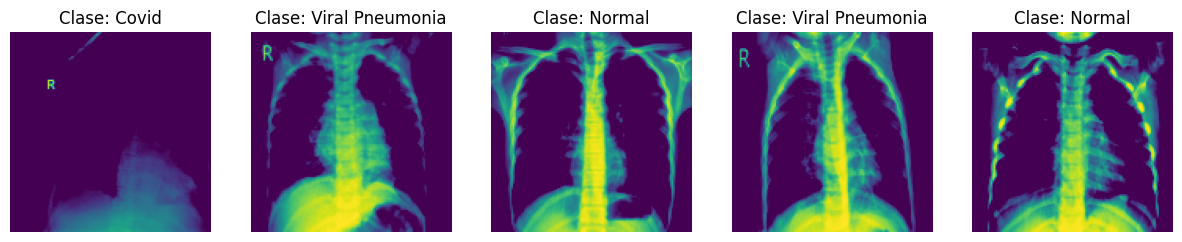

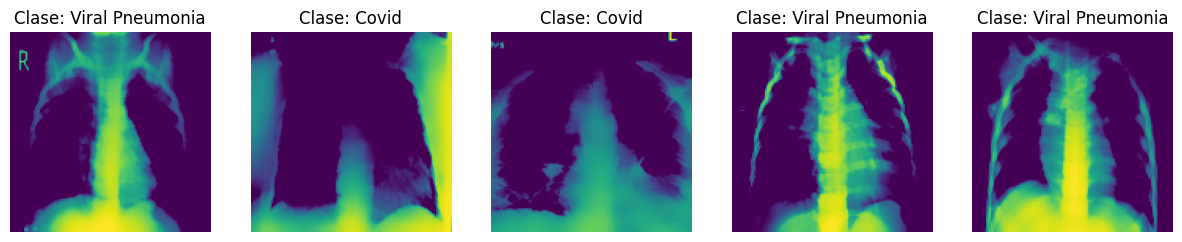

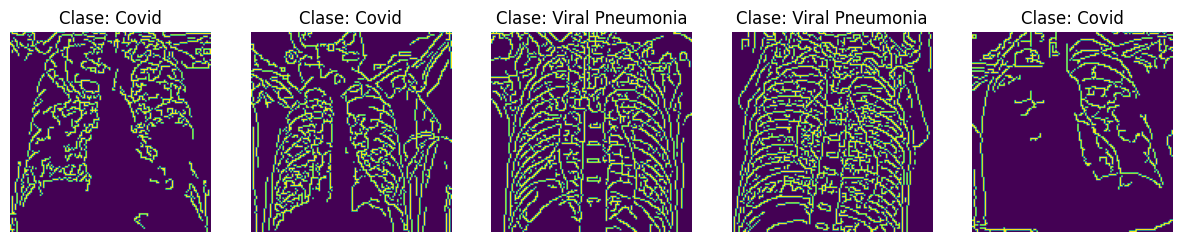

In [7]:
def show_first_five_images(data_loader, dataset):
    try:
        images, labels = next(iter(data_loader))
    except StopIteration:
        print("El DataLoader no tiene más datos.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")
    images = images.numpy().transpose((0, 2, 3, 1))
    images = np.clip(images, 0, 1)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for ax, img, label in zip(axes, images[:5], labels[:5]):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Clase: {dataset.classes[label.item()]}')
    plt.show()

show_first_five_images(train_loader_r, train_dataset_r)
show_first_five_images(train_loader_b, train_dataset_b)
show_first_five_images(train_loader_c, train_dataset_c)


Se ve reloko pq plt piensa q eso esta en RGB pero en realidad solo tiene un canal de color, eso es asi pq el modelo esta hecho para q acepte un solo canal de color.

# Creación del modelo B

In [8]:
# # Modelo que acepta 28x28
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(64 * 7 * 7, 64)  # 64 channels, 7x7 feature maps
#         self.fc2 = nn.Linear(64, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 64 * 7 * 7)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# Modelo que acepta 128x128
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 64)  # Reducción adicional
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 128 -> 64
        x = self.pool(F.relu(self.conv2(x)))  # 64 -> 32
        x = self.pool(F.relu(self.conv3(x)))  # 32 -> 16
        x = x.view(-1, 128 * 16 * 16)         # Aplanar
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model_a = CNN()

## Función de pérdida y optimizador para el modelo A

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_a.parameters(), lr=0.001)

# Entrenamiento del modelo A

In [10]:
def train(loader):
    for epoch in range(EPOCHS):
        for images, labels in loader:
            optimizer.zero_grad()  # Limpiar gradientes
            outputs = model_a(images)  # Pasar por la red
            loss = criterion(outputs, labels)  # Calcular la pérdida
            loss.backward()  # Propagación hacia atrás
            optimizer.step()  # Actualizar los parámetros

        print(f'Epoch [{epoch + 1}/{EPOCHS}], Loss: {loss.item():.4f}')

train(train_loader_r)

Epoch [1/5], Loss: 0.6066
Epoch [2/5], Loss: 0.1485
Epoch [3/5], Loss: 0.3891
Epoch [4/5], Loss: 0.1903
Epoch [5/5], Loss: 0.1821


# Evaluacion del modelo

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader_r:
        outputs = model_a(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

Accuracy of the model on the test images: 80.30%
